# CHE 630 Homework — Julia Notebook

## Setup
Create `figs/` folder and ensure required packages are available.

In [ ]:

# --- Setup ---
using Pkg
for pkg in ["Plots","Roots","ForwardDiff","Printf"]
    haskey(Pkg.project().dependencies, pkg) || Pkg.add(pkg)
end
using Plots, Roots, ForwardDiff, Printf
default(size=(820,480), legend=:outerright)
isdir("figs") || mkdir("figs")
println("Environment ready.")


## Problem 1(a): ẋ = 2 − x^2 + α sinh(x) — Bifurcation Diagram

(xstars, αstars) = ([-2.718390947679741, 2.718390947679741], [-0.7143369805802559, 0.7143369805802559])


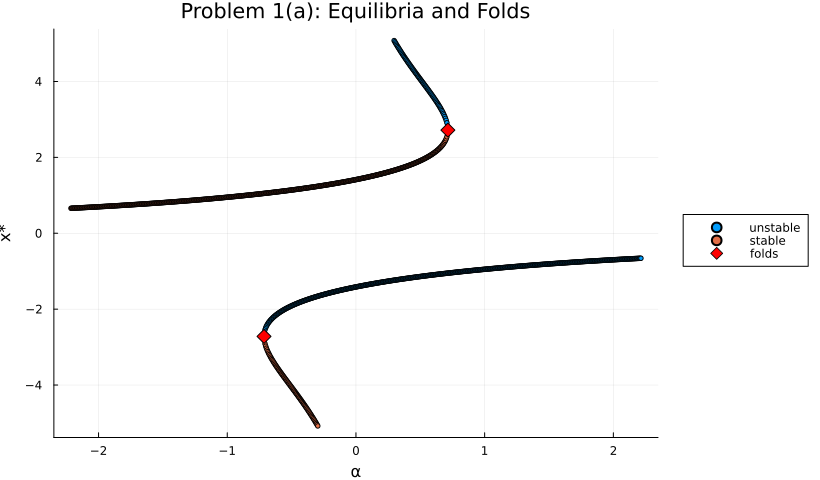

In [2]:

# f and derivatives
f(x, α)  = 2 - x^2 + α*sinh(x)
fx(x, α) = -2x + α*cosh(x)

# Fold condition g(x)=0 from (x^2-2)cosh x = 2x sinh x
g(x) = (x^2 - 2)*cosh(x) - 2x*sinh(x)

# Find fold x* (search symmetric roots)
xstars = Float64[]
for guess in [-3.0, -1.0, 1.0, 3.0]
    try
        xr = find_zero(g, guess; order=8)
        if all(abs(xr - y) > 1e-6 for y in xstars)
            push!(xstars, xr)
        end
    catch
    end
end
xstars = sort(xstars)
αstars = [ 2x/cosh(x) for x in xstars ]
@show xstars, αstars

# Scan α and track equilibria
αmin = minimum(αstars) - 1.5
αmax = maximum(αstars) + 1.5
αgrid = range(αmin, αmax, length=800)

function equilibria_at(α; guesses = [-4,-2,-1,0,1,2,4])
    roots = Float64[]
    for g0 in guesses
        try
            r = find_zero(x -> f(x, α), g0; order=8)
            if all(abs(r - z) > 1e-6 for z in roots)
                push!(roots, r)
            end
        catch
        end
    end
    sort(roots)
end

pts = Tuple{Float64,Float64,Bool}[]  # (α, x*, stable?)
for α in αgrid
    for x in equilibria_at(α)
        stab = fx(x, α) < 0
        push!(pts, (α,x,stab))
    end
end

plt = plot(xlabel="α", ylabel="x*", title="Problem 1(a): Equilibria and Folds")
αs = getindex.(pts,1); xs = getindex.(pts,2); st = getindex.(pts,3)
scatter!(plt, αs[.!st], xs[.!st], ms=2.5, label="unstable")
scatter!(plt, αs[st],   xs[st],   ms=2.5, label="stable")
scatter!(plt, αstars, xstars, ms=7, marker=:diamond, color=:red, label="folds")
savefig(plt, "figs/p1a_bifurcation.png"); plt


## Problem 1(b): ẋ = 2 cos(x) − r e^x (1 − x) — Multiple Folds

In [3]:

f(x, r)  = 2*cos(x) - r*exp(x)*(1 - x)
fx(x, r) = -2*sin(x) + r*x*exp(x)

# Critical state equation: x = sin x /(sin x + cos x)
h(x) = x - (sin(x) / (sin(x) + cos(x)))

xguesses = [-4.5,-3.2,-1.8,-0.6,0.6,1.8,3.2,4.5]
xstars = Float64[]
for g in xguesses
    try
        xr = find_zero(h, g; order=8)
        if isfinite(xr) && all(abs(xr - y) > 1e-6 for y in xstars)
            push!(xstars, xr)
        end
    catch
    end
end
xstars = sort(xstars)
rstars = [ 2*sin(x)/(x*exp(x)) for x in xstars ]
@show xstars, rstars

function equilibria_at_r(r; guesses = [-6,-4,-2,-1,0,1,2,4,6])
    roots = Float64[]
    for g0 in guesses
        try
            r0 = find_zero(x->f(x,r), g0; order=8)
            if all(abs(r0 - z) > 1e-6 for z in roots)
                push!(roots, r0)
            end
        catch
        end
    end
    sort(roots)
end

rgrid = range(minimum(rstars)-1.0, maximum(rstars)+1.0, length=900)
pts = Tuple{Float64,Float64,Bool}[]
for r in rgrid
    for x in equilibria_at_r(r)
        stab = fx(x, r) < 0
        push!(pts, (r,x,stab))
    end
end

plt = plot(xlabel="r", ylabel="x*", title="Problem 1(b): Multiple saddle–nodes")
rs = getindex.(pts,1); xs = getindex.(pts,2); st = getindex.(pts,3)
scatter!(plt, rs[.!st], xs[.!st], ms=2.5, label="unstable")
scatter!(plt, rs[st],   xs[st],   ms=2.5, label="stable")
scatter!(plt, rstars, xstars, marker=:diamond, ms=7, color=:red, label="folds")
savefig(plt, "figs/p1b_bifurcation.png"); plt


(xstars, rstars) = ([-0.7853981633974485, 0.0, 2.042786942738411], [3.9492916311626423, NaN, 0.11307073408990213])


ArgumentError: ArgumentError: start and stop must be finite, got NaN and NaN

## Problem 2: Maxwell–Bloch (adiabatic) — Pitchfork Diagram

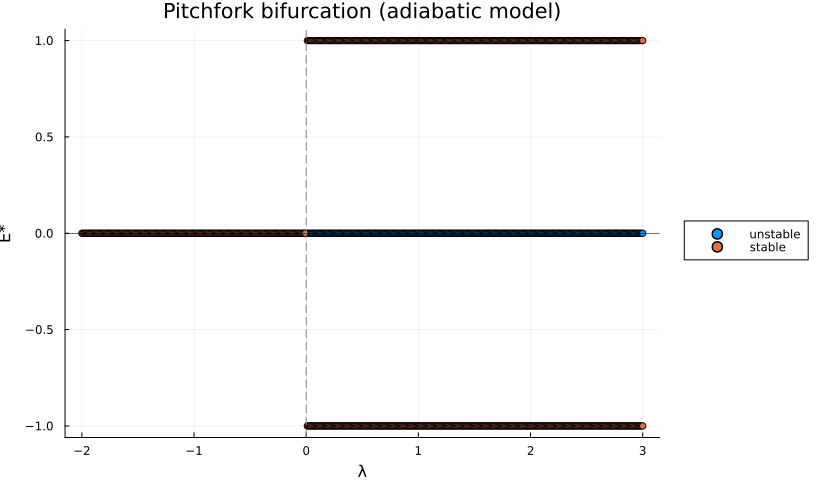

In [4]:

κ = 1.0
fE(E, λ) = κ*λ*E*(1 - E^2)/(1 + λ*E^2)

Ebranches(λ) = (λ <= 0) ? [0.0] : [0.0, -1.0, 1.0]
function stab(E, λ)
    if λ == 0
        return false
    elseif E == 0.0
        return (κ*λ < 0)
    elseif abs(E) == 1.0
        return (-2*κ*λ/(1+λ) < 0)
    else
        return false
    end
end

λgrid = range(-2, 3, length=501)
Es = Float64[]; Λs = Float64[]; ST = Bool[]
for λ in λgrid
    for E in Ebranches(λ)
        push!(Es, E); push!(Λs, λ); push!(ST, stab(E, λ))
    end
end

plt = plot(xlabel="λ", ylabel="E*", title="Pitchfork bifurcation (adiabatic model)")
scatter!(plt, Λs[.!ST], Es[.!ST], ms=3.5, label="unstable")
scatter!(plt, Λs[ST],  Es[ST],  ms=3.5, label="stable")
hline!([0], lc=:black, lw=0.5, label=false)
vline!([0], lc=:gray, ls=:dash, lw=1, label=false)
savefig(plt, "figs/p2_pitchfork.png"); plt


## Problem 6: Sequence y_{n+1} = (−0.7)^{n+1} y_n

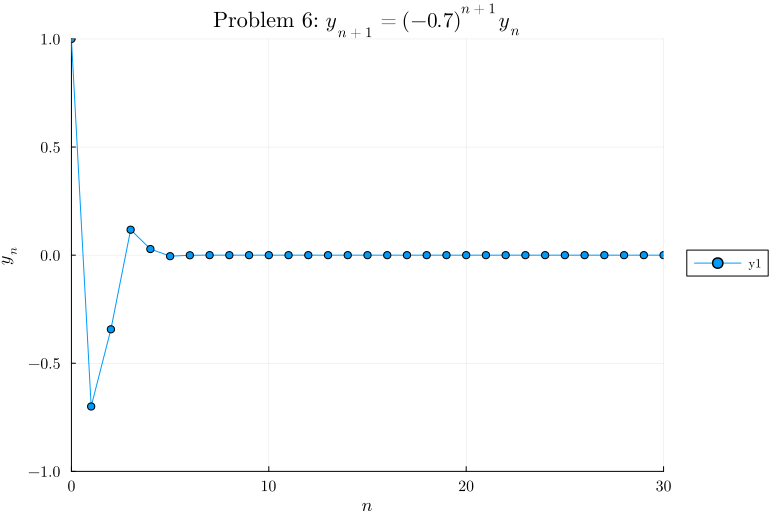

In [7]:

using Plots, LaTeXStrings
y0 = 1.0
N = 30
ys = zeros(Float64, N+1); ys[1] = y0
for n in 0:N-1
    ys[n+2] = (-0.7)^(n+1) * ys[n+1]
end
ns = 0:N
plt = plot(ns, ys, marker=:circle, xlabel=L"n", ylabel=L"y_n",
           title="Problem 6: "*L"y_{n+1} = (-0.7)^{n+1} y_n",
           fontfamily="Computer Modern", titlefontsize=14, guidefontsize=12, 
           tickfontsize=10, xlims=(0,N), ylims=(-1,1))
savefig(plt, "figs/p6_sequence.png"); plt


## Problem 7: Mortgage cap — Solve for maximum APR

In [8]:

using Roots, Printf
P = 120_000.0
N = 15*12              # months
function payment(r_annual)  # nominal APR, monthly comp.
    i = r_annual/12
    i == 0 && return P/N
    return P * i*(1+i)^N / ((1+i)^N - 1)
end

caps = [800.0, 600.0, 400.0]
@printf("%-8s  %-12s  %-12s\n","Cap","r_max (APR)","Feasible?")
for Mmax in caps
    f(r) = payment(r) - Mmax
    r = try
        find_zero(f, 0.03; order=8)   # start near 3%
    catch
        NaN
    end
    feas = (payment(0.0) <= Mmax) || (!isnan(r) && r > 0)
    if feas
        @printf("\$%-7.0f  %8.4f %%     %s\n", Mmax, 100*r, "yes")
    else
        @printf("\$%-7.0f  %12s  %s (needs longer term or lower P)\n",
                Mmax, "N/A", "no")
    end
end


Cap       r_max (APR)   Feasible?   
$800        2.4974 %     yes
$600               N/A  no (needs longer term or lower P)
$400               N/A  no (needs longer term or lower P)


## Problem 8: Modified logistic with harvesting

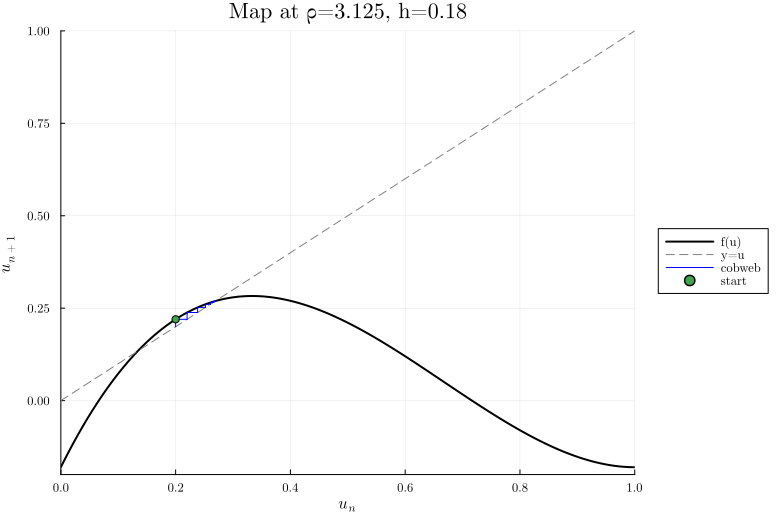

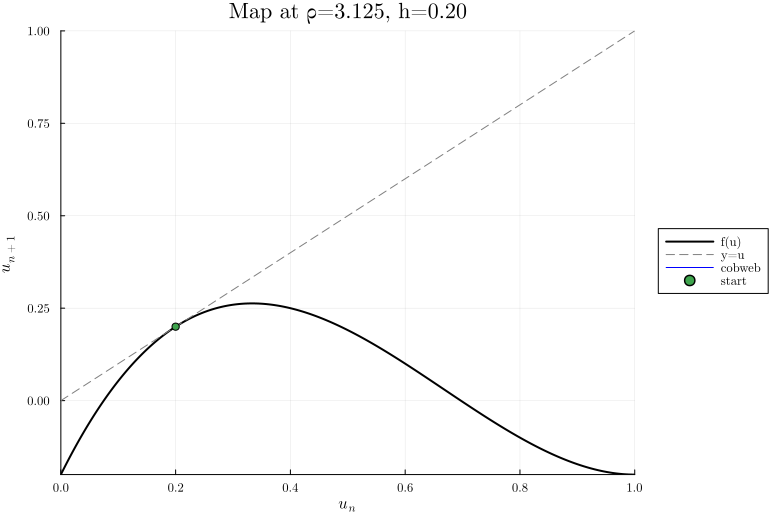

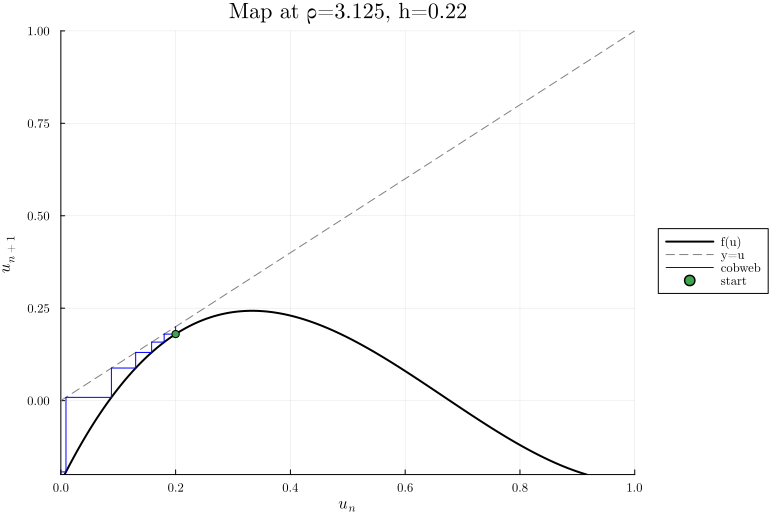

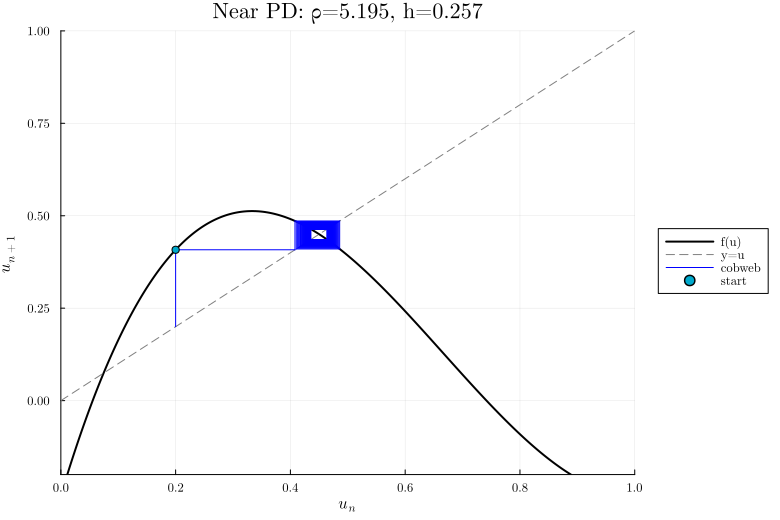

In [12]:

using Plots, LaTeXStrings; default(legend=:outerright, fontfamily="Computer Modern")
f(u, ρ, h) = ρ*u*(1-u)^2 - h

function cobweb!(plt, ρ, h; u0=0.2, n=80, xrange=(0.0,1.0))
    x = range(xrange[1], xrange[2], length=400)
    y = [f(u,ρ,h) for u in x]
    plot!(plt, x, y, lw=2, label="f(u)", color=:black)
    plot!(plt, x, x, lw=1, ls=:dash, label="y=u", color=:gray)
    # Iterate
    u = u0
    for k in 1:n
        un = f(u, ρ, h)
        plot!(plt, [u,u], [u,un], lw=1, color=:blue, label=(k==1 ? "cobweb" : false))
        plot!(plt, [u,un], [un,un], lw=1, color=:blue, label=false)
        u = un
        if !isfinite(u) || abs(u) > 5
            break
        end
    end
    scatter!(plt, [u0], [f(u0,ρ,h)], ms=4, label="start")
    return plt
end

# Saddle–node illustrations at ρ=3.125
ρ_SN = 3.125
for h in [0.18, 0.20, 0.22]
    plt = plot(xlabel=L"u_n", ylabel=L"u_{n+1}",
               title = @sprintf("Map at ρ=%.3f, h=%.2f", ρ_SN, h))
    cobweb!(plt, ρ_SN, h; u0=0.2, n=120)
    xlims!(plt,0,1); ylims!(plt, -0.2, 1.0)
    savefig(plt, "figs/p8_SN_h$(round(Int,100*h)).png")
    display(plt)
end

# Period–doubling example near (ρ,h) ≈ (5.195, 0.257)
ρ_PD = 5.195
h_PD = 0.257
plt = plot(xlabel=L"u_n", ylabel=L"u_{n+1}",
           title = @sprintf("Near PD: ρ=%.3f, h=%.3f", ρ_PD, h_PD))
cobweb!(plt, ρ_PD, h_PD; u0=0.2, n=140)
xlims!(plt,0,1); ylims!(plt, -0.2, 1.0)
savefig(plt, "figs/p8_PD.png"); plt
